## Importar librerias

In [6]:
# Importar librerias necesarias
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
import session_info
import upsetplot


## Configurar el aspecto general de las graficas del proyecto

In [7]:
%matplotlib inline

sns.set(rc={'figure.figsize':(10,10)})

sns.set_style("whitegrid")

### Operar con valores faltantes

#### Python

In [8]:
print(None or True,
      None or True,
      None == None,
      None is None,
      type(None)
      )

True True True True <class 'NoneType'>


### Nympy

In [9]:
print(np.nan or True,
      np.nan == np.nan,
      np.nan is np.nan,
      np.nan /  2,
      type(np.nan),
      type(np.nan) is float,
      sep='\n'
      )

nan
False
True
nan
<class 'float'>
True


### Pandas


In [10]:
test_missing_df = pd.DataFrame.from_dict(
    data = dict(
        x= [0,1, np.nan, np.nan, None],
        y= [0,1, pd.NA, np.nan, None]
        )
    )

test_missing_df

,x,y
0,0.0,0
1,1.0,1
2,NaN,<NA>
3,NaN,NaN
4,NaN,None


## Cargar los conjuntos de datos

#### Pima Indians Diabetes

In [11]:
diabetes_df = pd.read_csv("diabetes.csv")
diabetes_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


### Crear una nueva clase para extender pandas

In [12]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    """
    Custom accessor for DataFrame to check for missing values.
    """
    def __init__(self, pandas_obj):
        self._df = pandas_obj

    def number_missing(self):
        """
        Returns the number of missing values in the DataFrame.
        """
        return self._df.isna().sum().sum()
    
    def number_complete(self):
        """
        Returns the number of complete rows in the DataFrame.
        """
        return self._df.size - self._df.missing.number_missing()



### Probar su uso

In [13]:
df = pd.DataFrame.from_dict(
    data = {
        "a" : list("abcdradcdx"),
        "b": range(0,10)  
    }
)

df.iloc[2:5, 0] = None
df.iloc[6:7, 1] = None


In [14]:
df = pd.DataFrame(df)

In [15]:
df.missing.number_missing()

np.int64(4)

In [16]:
df.missing.number_complete()

np.int64(16)

# Extensión de la API de Pandas

In [17]:
import itertools
import pandas as pd
import upsetplot

In [18]:
try:
    del pd.DataFrame.missing
except AttributeError:
    pass

In [19]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_variable", 0: "n_variables"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_case_table(self) -> pd.DataFrame():
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_case", 0: "n_cases"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending = False):

        return (
            self._obj
            .pipe(
                lambda df: (
                    df[df.isna().sum().sort_values(ascending = ascending).index]
                )
            )
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return (
            self._obj
            .isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix("_NA")
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing
                )
            ],
            axis="columns"
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )

    # Plotting functions ---

    def missing_variable_plot(self):
        df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

        plt.plot(df.n_missing, plot_range, "o", color="black")

        plt.yticks(plot_range, df.variable)

        plt.grid(axis="y")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", binwidth=1, color="black")

        plt.grid(axis="x")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)

    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )

## Tabulación de valores faltantes

In [20]:
diabetes_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Resumen basico de valores faltantes

In [21]:
diabetes_df.shape

(768, 9)

### Numero total de valores completos (sin observaciones faltantes)

In [22]:
diabetes_df.missing.number_complete()

np.int64(6912)

### Numero total de valores faltantes

In [23]:
diabetes_df.missing.number_missing()

np.int64(0)

## Resumen tabulares de valores faltantes

#### Variables / Columnas 

#### Resumen por variable

In [24]:
diabetes_df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,Pregnancies,0,768,0.0
1,Glucose,0,768,0.0
2,BloodPressure,0,768,0.0
3,SkinThickness,0,768,0.0
4,Insulin,0,768,0.0
5,BMI,0,768,0.0
6,DiabetesPedigreeFunction,0,768,0.0
7,Age,0,768,0.0
8,Outcome,0,768,0.0


#### Intervalos de valores faltantes

In [25]:
diabetes_df.missing.missing_variable_span(span_every=50, variable="Glucose")

,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,0,50,0.0,100.0
1,1,0,50,0.0,100.0
2,2,0,50,0.0,100.0
3,3,0,50,0.0,100.0
4,4,0,50,0.0,100.0
5,5,0,50,0.0,100.0
6,6,0,50,0.0,100.0
7,7,0,50,0.0,100.0
8,8,0,50,0.0,100.0
9,9,0,50,0.0,100.0


## Visualizacion de valores faltantes

### Variable

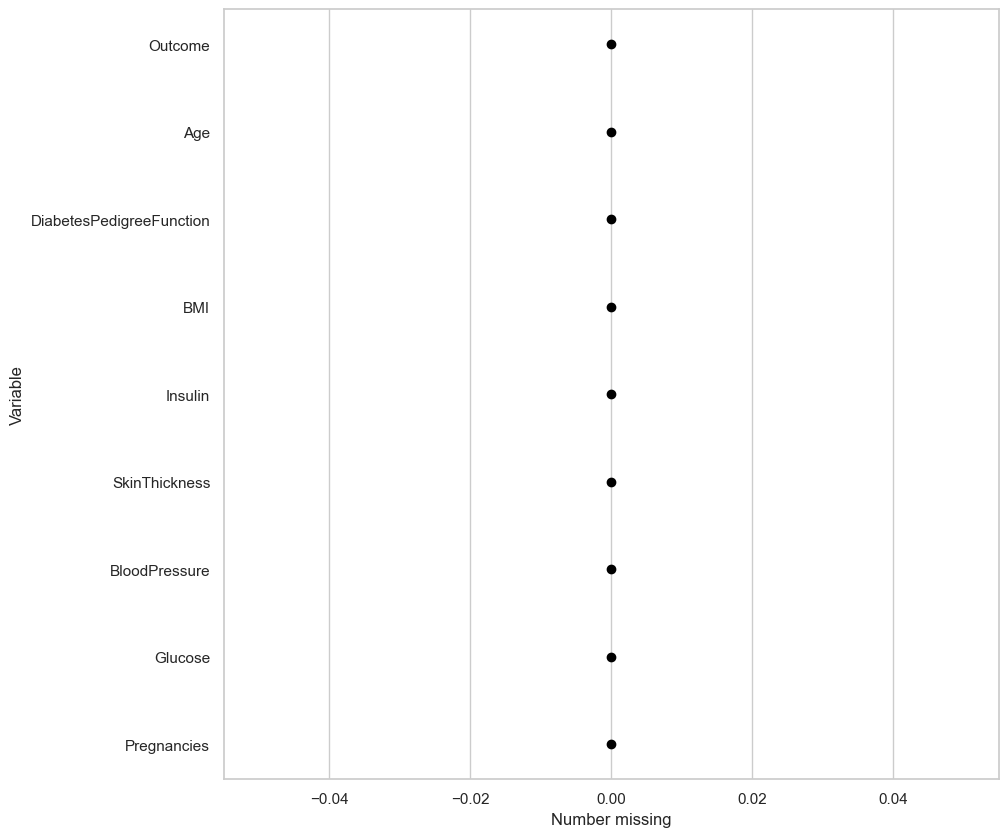

In [26]:
diabetes_df.missing.missing_variable_plot()

### Casos / Observaciones / Filas

In [27]:
# diabetes_df.missing.missing_case_plot()

## Codificacion de valores faltantes

In [28]:
missing_data_example_df = pd.DataFrame.from_dict(
    dict(
        x = [1, 3 , "NA", -99, -98, -99],
        y = ["A", "N/A", "NA", "E", "F", "G"],
        z = [-100, -99, -98, -101, -1, -1]
    )
)

missing_data_example_df

,x,y,z
0,1,A,-100
1,3,N/A,-99
2,NA,NA,-98
3,-99,E,-101
4,-98,F,-1
5,-99,G,-1


#### Revisar los tipos de datos

In [29]:
missing_data_example_df.dtypes

x    object
y    object
z     int64
dtype: object

#### Revisar valores unicos de los datos

In [30]:
missing_data_example_df.x.unique()

array([1, 3, 'NA', -99, -98], dtype=object)

In [31]:
missing_data_example_df.select_dtypes(object).apply(pd.unique)

x     [1, 3, NA, -99, -98]
y    [A, N/A, NA, E, F, G]
dtype: object

#### Sustitucion global

In [32]:
missing_data_example_df.replace(to_replace=[-99, "NA"], value=np.nan)

C:\Users\david\AppData\Local\Temp\ipykernel_3208\3319056906.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_data_example_df.replace(to_replace=[-99, "NA"], value=np.nan)


,x,y,z
0,1.0,A,-100.0
1,3.0,N/A,NaN
2,NaN,NaN,-98.0
3,NaN,E,-101.0
4,-98.0,F,-1.0
5,NaN,G,-1.0


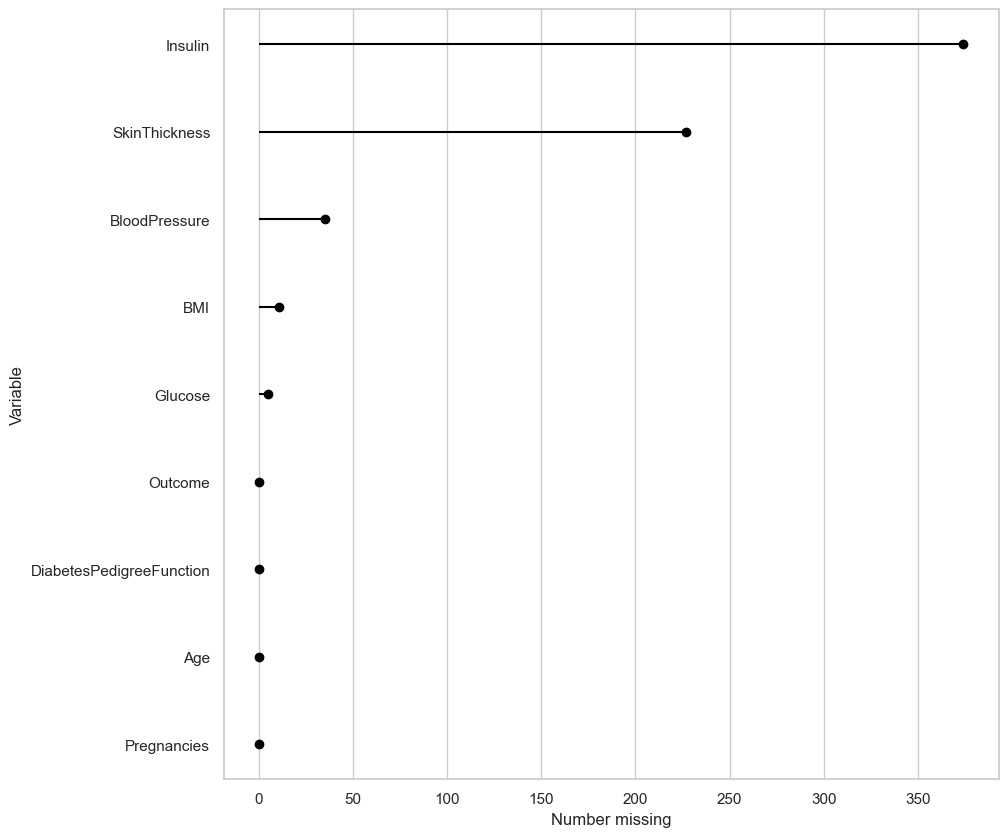

In [33]:
diabetes_df[diabetes_df.columns[1:6]] = diabetes_df[diabetes_df.columns[1:6]].replace(0, np.nan)
diabetes_df.missing.missing_variable_plot()

## Missing Completely At Random (MCAR)

<Axes: >

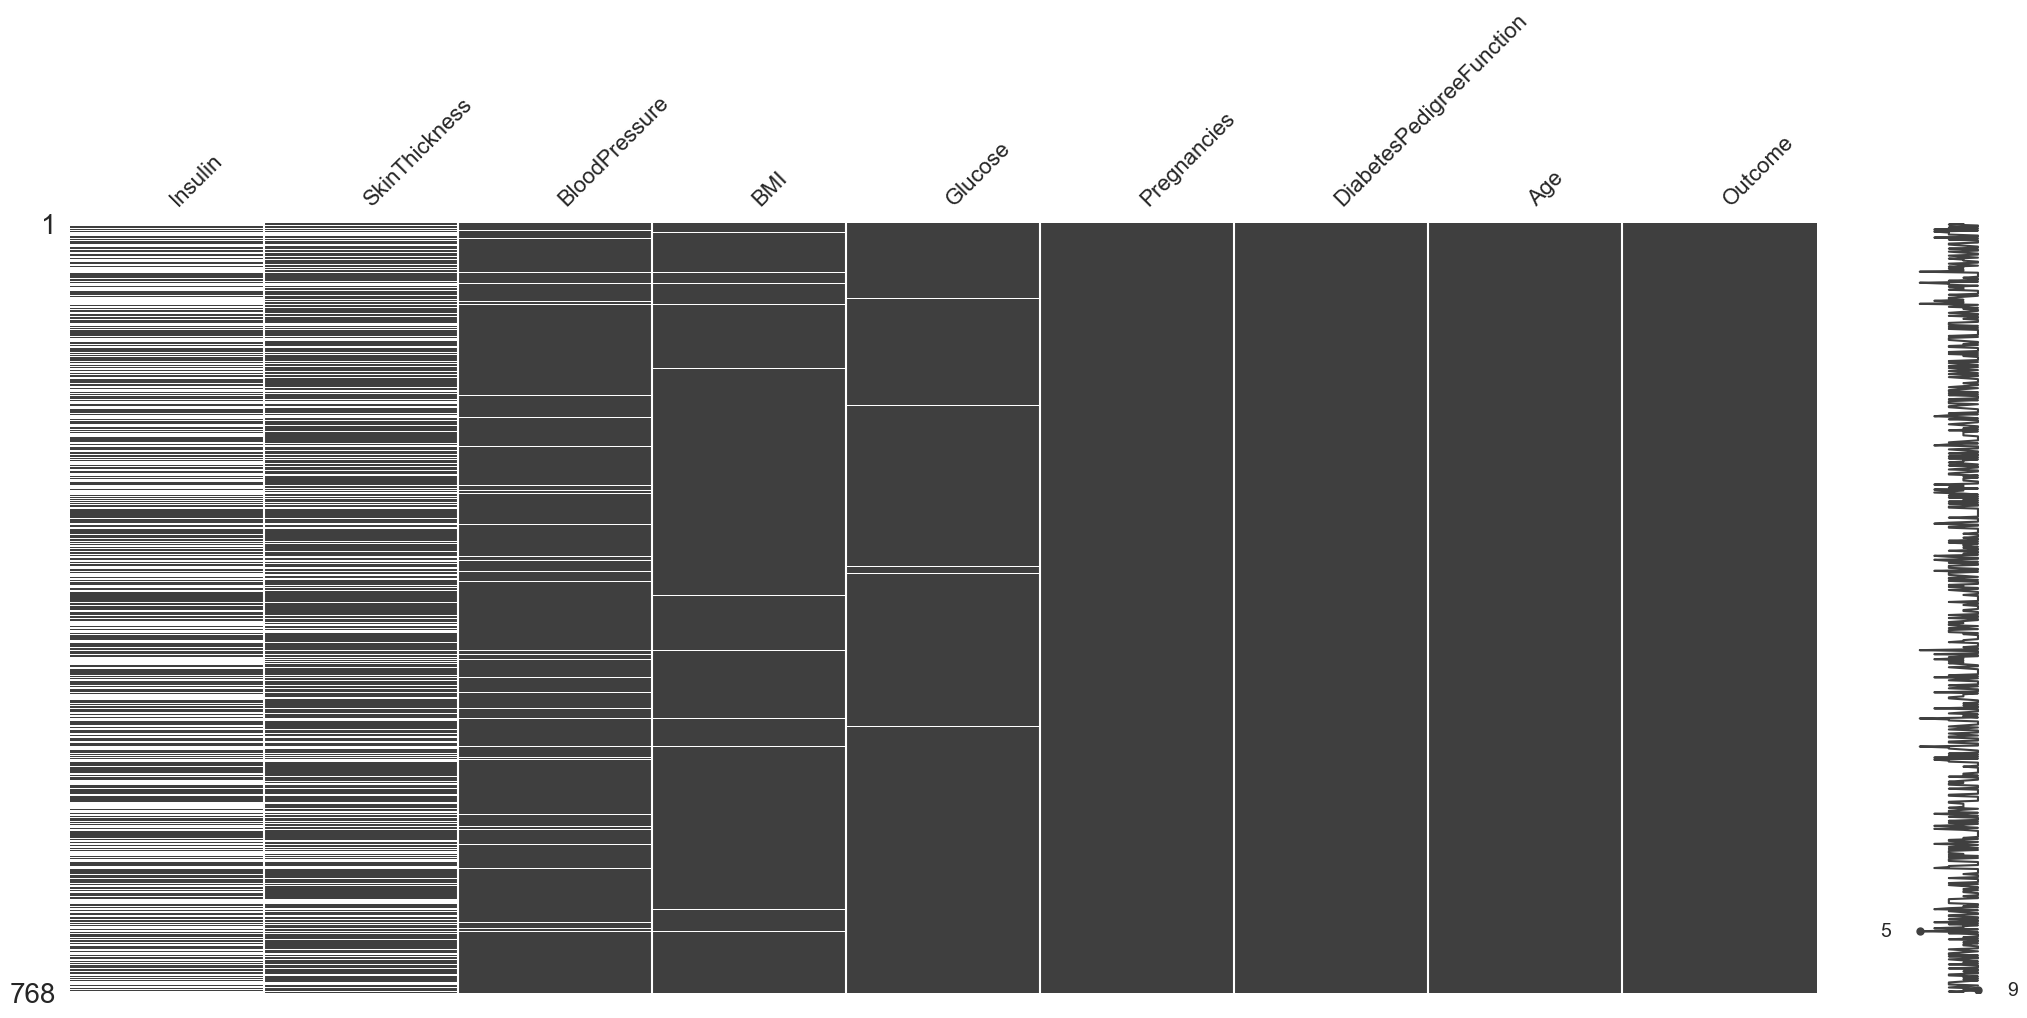

In [34]:
import missingno as msno

sorted_df = diabetes_df.missing.sort_variables_by_missingness()
msno.matrix(sorted_df)

## Missing At Random (MAR)

<Axes: >

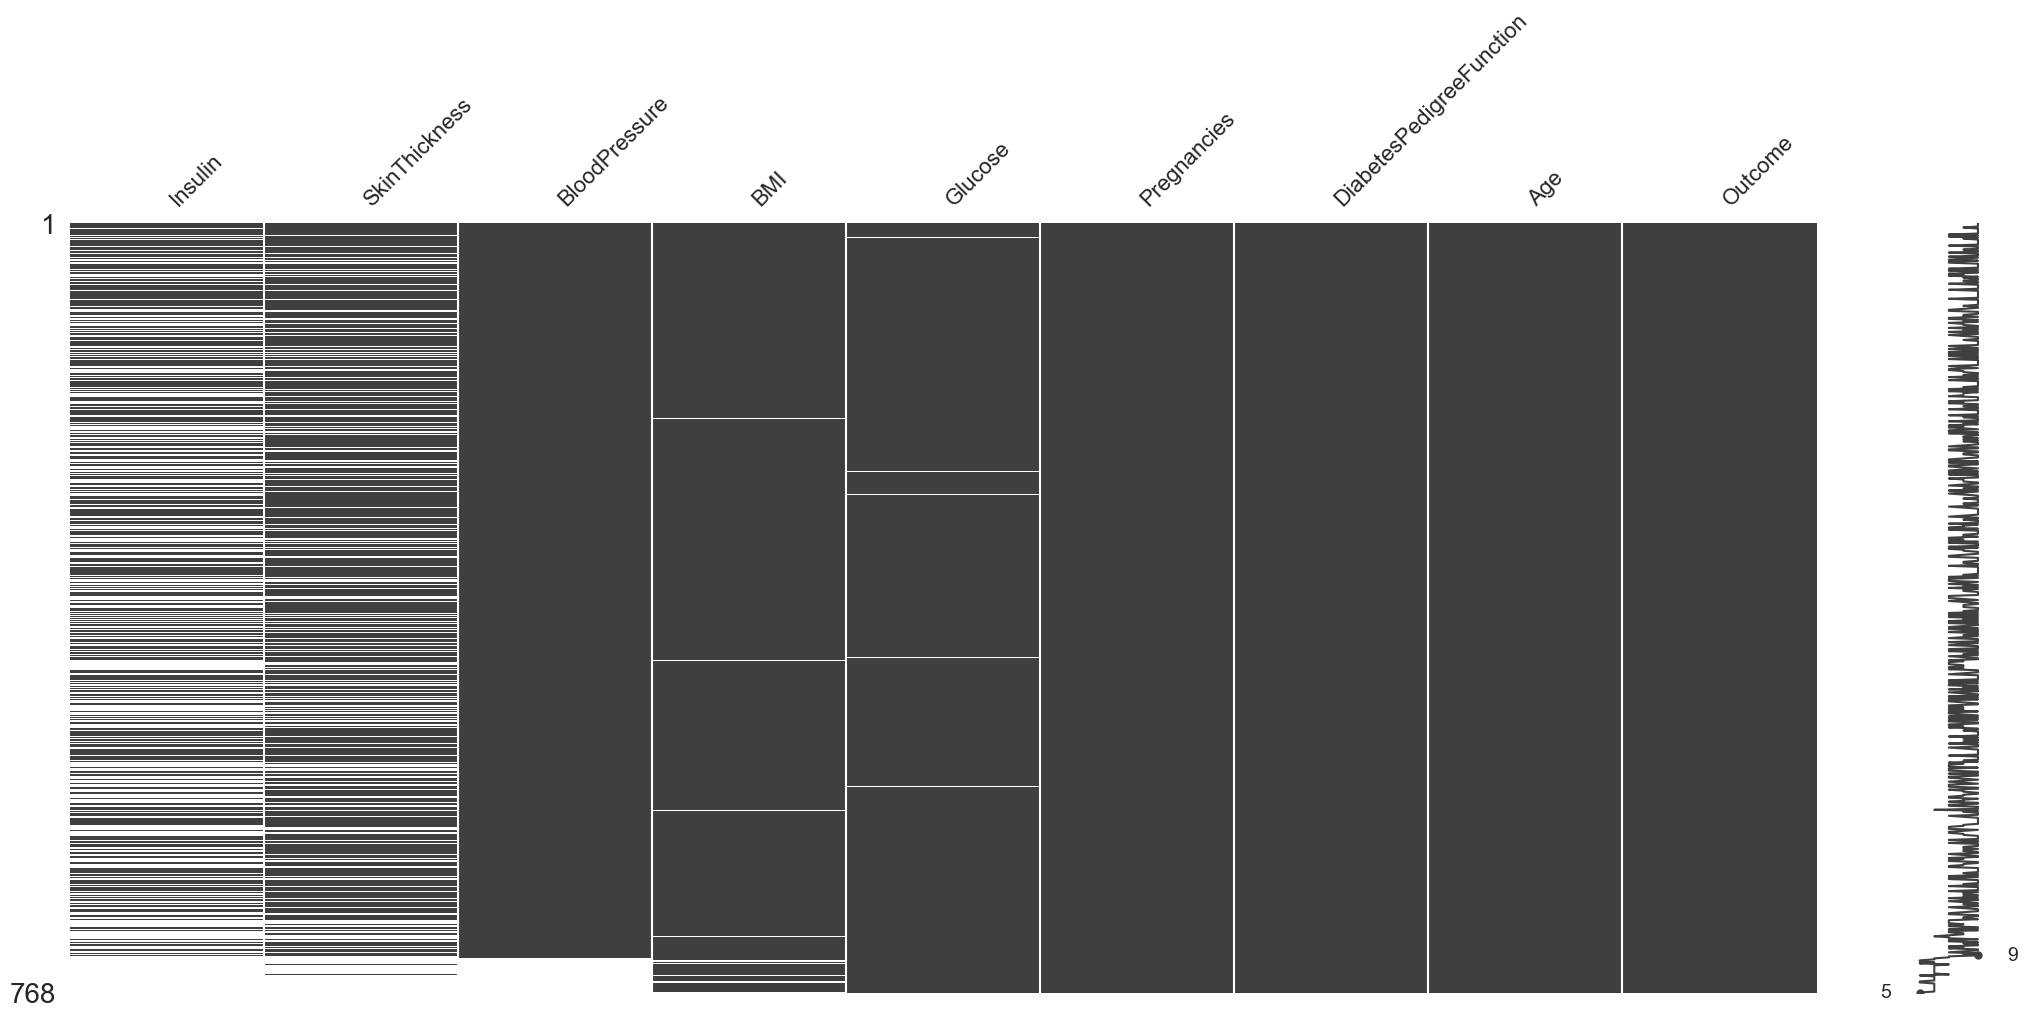

In [35]:
diabetes_df.missing.sort_variables_by_missingness().sort_values(by = "BloodPressure").pipe(missingno.matrix)

##  Missing Not At Random (MNAR)

<Axes: >

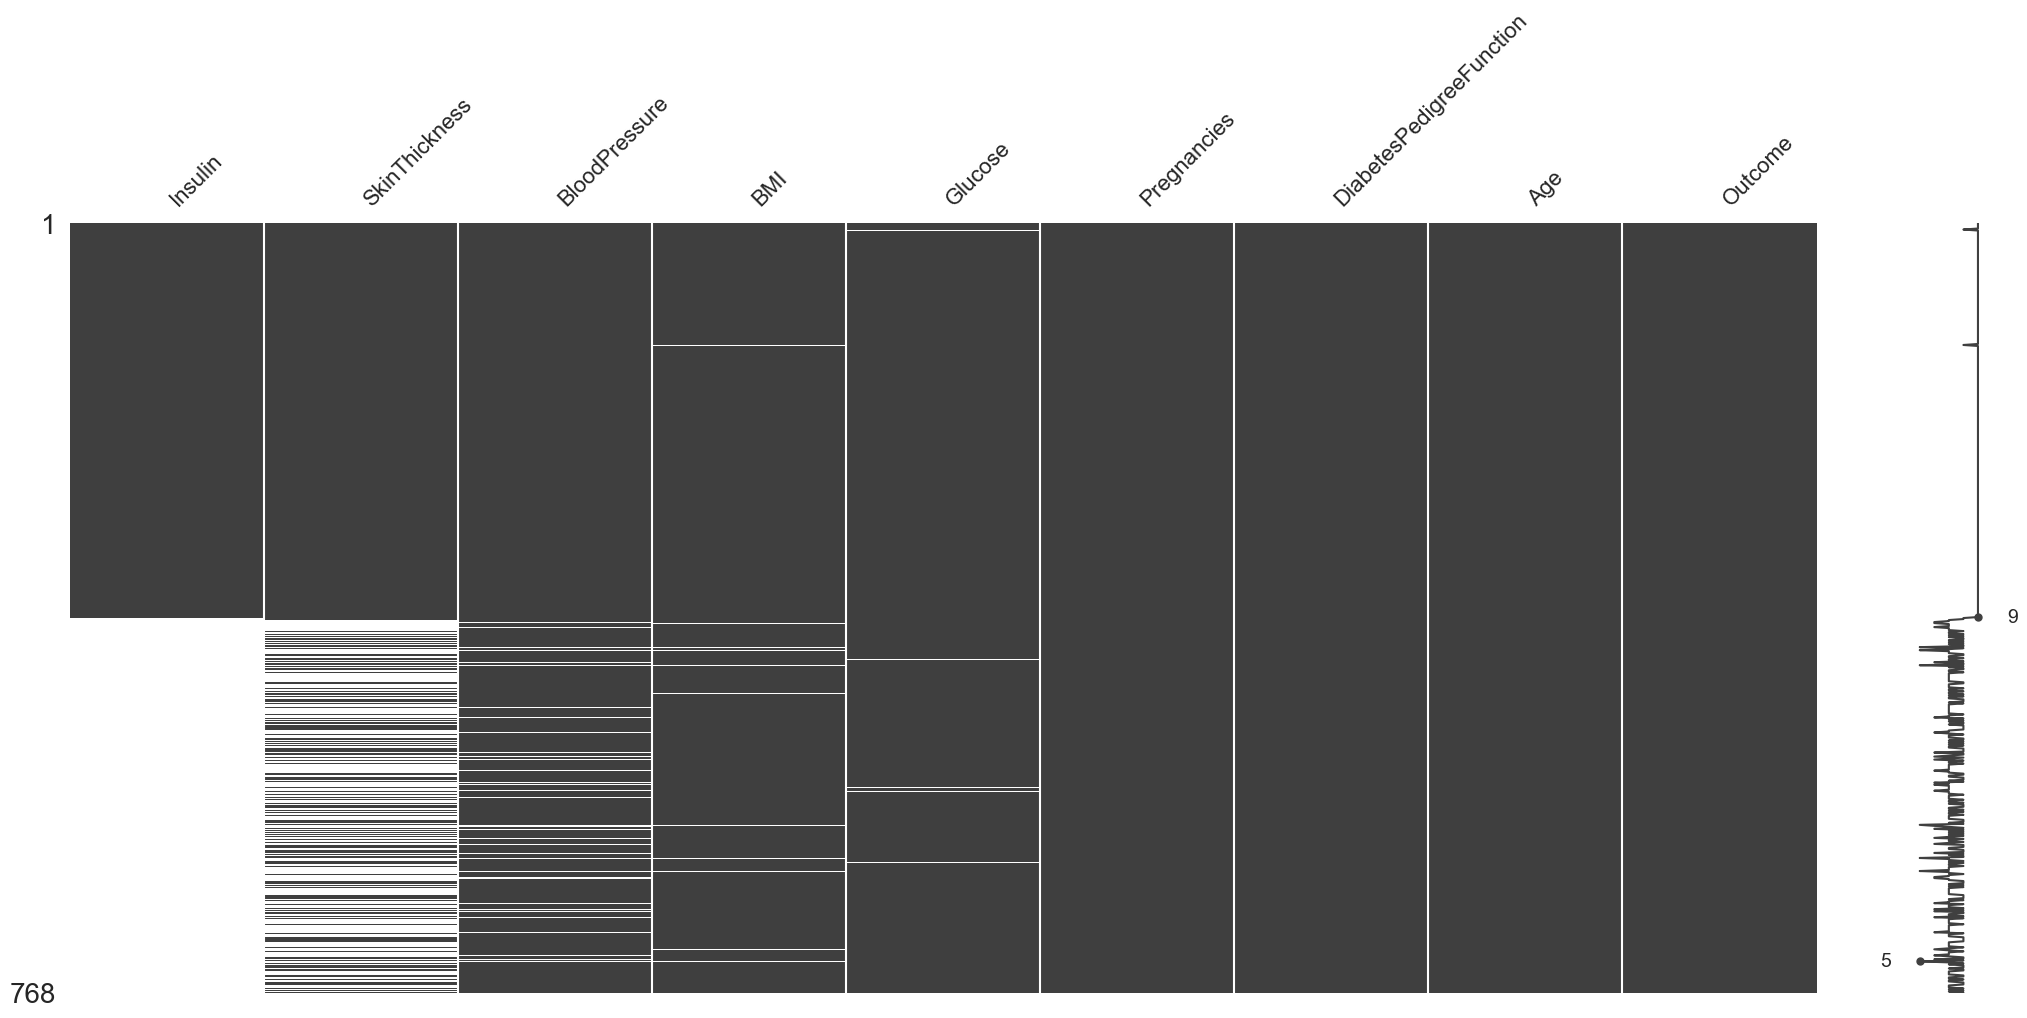

In [36]:
diabetes_df.missing.sort_variables_by_missingness().sort_values(by = "Insulin").pipe(missingno.matrix)

In [37]:
risk_factors_df = pyreadr.read_r('riskfactors.rda')['riskfactors']
risk_factors_df.head(10)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
5,19,Male,66,165,70,23.72,Married,NaN,0,5,...,No,NaN,NaN,NaN,24,52,104,52,365,365
6,45,Male,37,150,68,22.86,Married,NaN,3,6,...,No,NaN,NaN,NaN,52,156,24,24,730,104
7,56,Female,62,170,70,24.44,NeverMarried,NaN,0,6,...,Yes,Not@All,NaN,7,156,24,52,104,365,0
8,18,Male,38,146,70,20.99,Married,NaN,2,4,...,Yes,Everyday,Yes,NaN,24,84,144,24,0,0
9,8,Female,42,260,73,34.37,Separated,No,3,5,...,Yes,Not@All,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN


## Construccion de matriz de sombras

In [38]:
risk_factors_df.isna().replace({False: "Not Missing", True: "Missing"}).add_suffix("_NA").pipe(lambda shadow_matrix: pd.concat([risk_factors_df, shadow_matrix], axis = "columns"))

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100_NA,smoke_days_NA,smoke_stop_NA,smoke_last_NA,diet_fruit_NA,diet_salad_NA,diet_potato_NA,diet_carrot_NA,diet_vegetable_NA,diet_juice_NA
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,Not Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing


### Utilizar funcion de utileria bind_shadow_matrix()

In [39]:
risk_factors_df.missing.bind_shadow_matrix(only_missing=True)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100_NA,smoke_days_NA,smoke_stop_NA,smoke_last_NA,diet_fruit_NA,diet_salad_NA,diet_potato_NA,diet_carrot_NA,diet_vegetable_NA,diet_juice_NA
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,Not Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing


### Explorar estadisticos utilizando las nuevas columnas de la matriz de sombras

In [40]:
risk_factors_df.missing.bind_shadow_matrix(only_missing=True).groupby(["weight_lbs_NA"])["age"].describe()

,count,mean,std,min,25%,50%,75%,max
weight_lbs_NA,,,,,,,,
Missing,10.0,60.100000,13.706851,37.0,52.25,62.5,65.0,82.0
Not Missing,235.0,58.021277,17.662904,7.0,47.50,59.0,70.0,97.0


<Axes: xlabel='weight_lbs_NA', ylabel='age'>

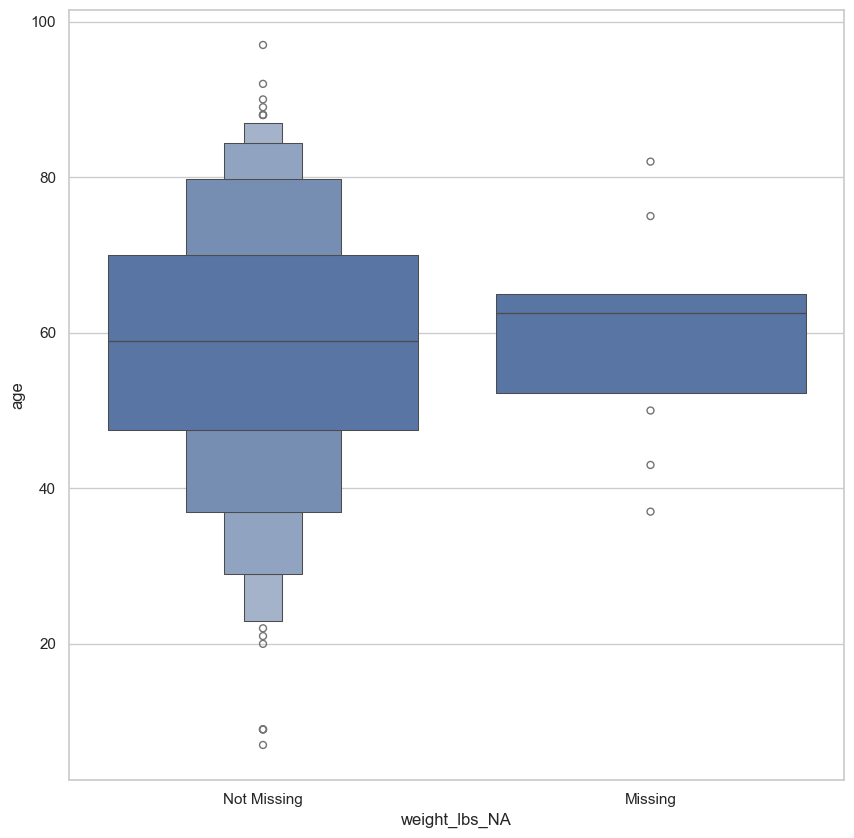

In [41]:
risk_factors_df.missing.bind_shadow_matrix(only_missing=True).pipe(lambda df:(sns.boxenplot(data=df, x = "weight_lbs_NA", y = "age")))

## Visualizacion de valores faltantes en dos variables

In [42]:
def column_fill_with_dummies(
    column: pd.Series,
    proportion_below: float = 0.10,
    jitter: float = 0.75,
    seed: int = 42,
) -> pd.Series:
    
    column = column.copy(deep=True)

    #Extract values metadata
    missing_mask = column.isna()
    number_missing_values = missing_mask.sum()
    column_range = column.max() - column.min()

    #Shift data
    column_shift = column.min() - column_range * proportion_below

    #Create the "jitter" (noise) to be added around the points.
    np.random.seed(seed)
    column_jitter = (np.random.rand(number_missing_values) -2) * column_range * jitter

    # save new dummy data
    column[missing_mask] = column_shift + column_jitter
    return column

<Axes: xlabel='weight_lbs', ylabel='height_inch'>

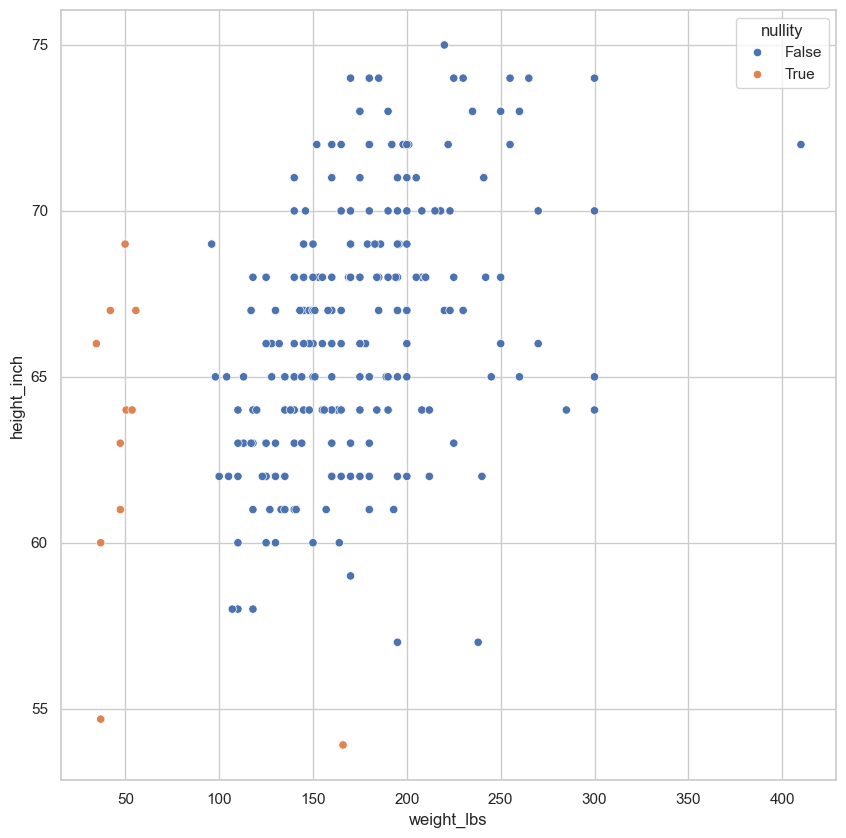

In [43]:
(
    risk_factors_df
    .select_dtypes(
        exclude='category'  # excluye las variables categoricas
    )
    .pipe(
        lambda df: df[df.columns[df.isna().any()]] #seleccionar solo columnas que tengan valores faltantes
    )
    .missing.bind_shadow_matrix(true_string = True, false_string = False)
    .apply(
        lambda column: column if '_NA' in column.name else column_fill_with_dummies(column, proportion_below=0.05, jitter=0.075)
    )
    .assign(
        nullity = lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
    .pipe(
        lambda df: (
            sns.scatterplot(
                data = df,
                x='weight_lbs',
                y= 'height_inch',
                hue='nullity'
            )
        )
    )
)

## Correlacion de nulidad

<Axes: >

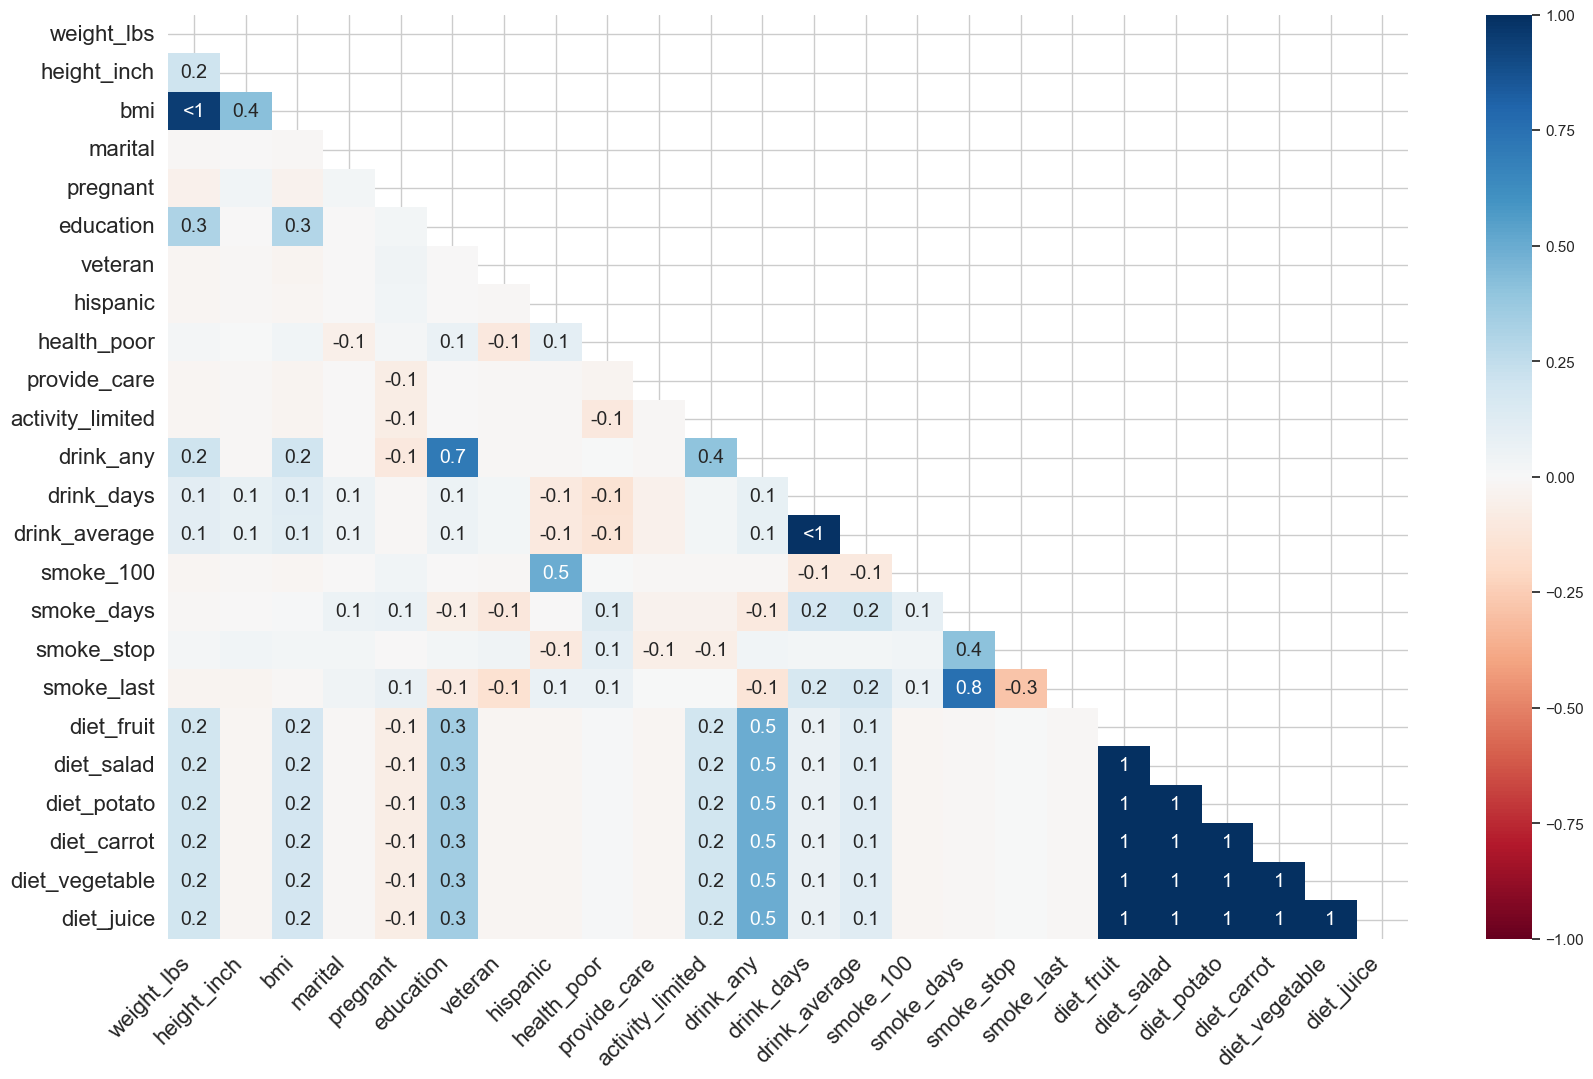

In [44]:
missingno.heatmap(df=risk_factors_df)

## Eliminacion de valores faltantes

In [45]:
risk_factors_df.shape

(245, 34)

#### Pairwise deletion (eliminacion por pares)

In [46]:
risk_factors_df.weight_lbs.mean()

np.float64(174.26808510638298)

In [47]:
risk_factors_df.weight_lbs.size, risk_factors_df.weight_lbs.count()

(245, np.int64(235))

### Listwise Deletion or complete case (Eliminacion por lista o caso completo)

#### Con base en 1 columna.

In [48]:
risk_factors_df.dropna(subset=["weight_lbs"], how='any')

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,No,NaN,NaN,NaN,-7,-7,-7,-7,-7,-7
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,No,NaN,NaN,NaN,52,52,52,24,52,24
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Yes,Not@All,NaN,7,365,156,104,52,730,365
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Yes,Everyday,No,NaN,730,0,24,156,104,0


#### Con base en 2 o mas columnas

In [49]:
risk_factors_df.dropna(subset=["weight_lbs", "height_inch"], how="any").shape

(234, 34)

#### Representacion grafica tras la eliminacion de los valores faltantes

d:\david\learning_platzi\dataScientistPython\manejo_datos_faltantes\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


<Axes: >

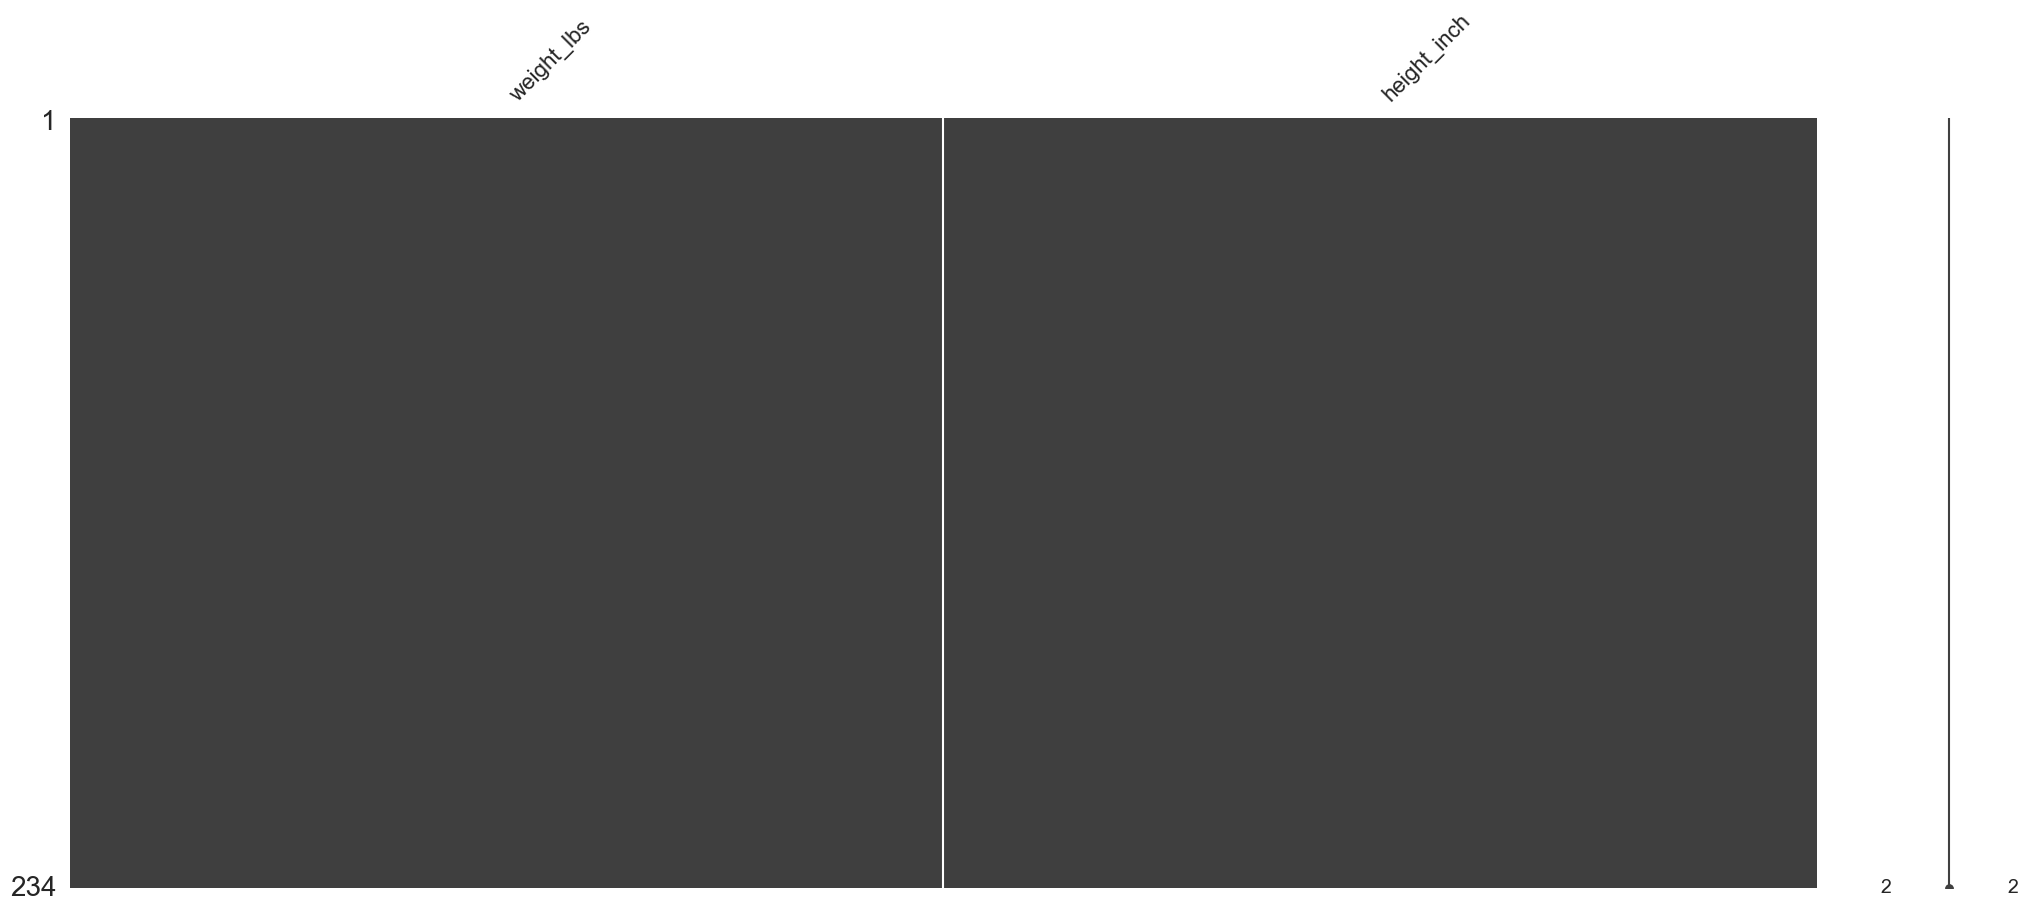

In [50]:
risk_factors_df.dropna(subset=["weight_lbs", "height_inch"], how="any").select_columns(["weight_lbs", "height_inch"]).pipe(missingno.matrix)

## Imputacion basica de valores faltantes

#### Imputacion con base en el contexto

In [51]:
implicit_to_explicit_df = pd.DataFrame(
    data={
        "name": ["lynn", np.nan, "zelda", np.nan, "shadowsong", np.nan],
        "time": ["morning", "afternoon", "morning", "afternoon", "morning", "afternoon",],
        "value": [350, 310, 320, 350, 310, 320]
    }
)

implicit_to_explicit_df

,name,time,value
0,lynn,morning,350
1,NaN,afternoon,310
2,zelda,morning,320
3,NaN,afternoon,350
4,shadowsong,morning,310
5,NaN,afternoon,320


In [52]:
implicit_to_explicit_df.ffill()

,name,time,value
0,lynn,morning,350
1,lynn,afternoon,310
2,zelda,morning,320
3,zelda,afternoon,350
4,shadowsong,morning,310
5,shadowsong,afternoon,320


d:\david\learning_platzi\dataScientistPython\manejo_datos_faltantes\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
C:\Users\david\AppData\Local\Temp\ipykernel_3208\3703242658.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  func = lambda column: column.fillna(column.mean())if "_NA" not in column.name else column


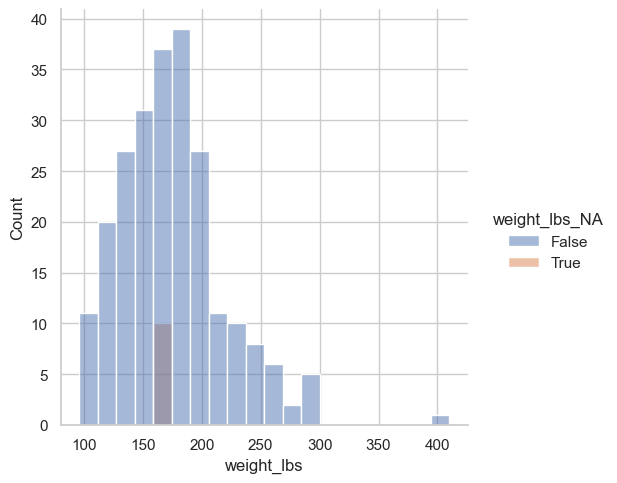

In [56]:
(
    risk_factors_df
    .select_columns("weight_lbs", "height_inch", "bmi")
    .missing.bind_shadow_matrix(true_string = True, false_string = False)
    .apply(
        axis= "rows", 
        func = lambda column: column.fillna(column.mean())if "_NA" not in column.name else column
    )
).pipe(
    lambda df:(
        sns.displot(
            data=df,
            x='weight_lbs',
            hue='weight_lbs_NA'
        )
    )
)